In [49]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys
from astropy.table import Table
import scipy
import pyccl as ccl
import astropy.units as u
from scipy import interpolate
from astropy.coordinates import SkyCoord
from clmm.dataops import _compute_lensing_angles_flatsky
from clmm import Cosmology
import clmm
from clmm.dataops import _compute_lensing_angles_flatsky
sys.path.append('../modules/')
import clmm
import shear_multipole_modeling as mlt
#import shear_multipole_modeling as model
import shear_multipole_from_data
import lensing_simulation_tools
import clmm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.27 - 0.045, Omega_b=0.045, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)
moo = clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'einasto')
moo.set_concentration(4)
moo.set_mass(1e15)

In [51]:
lensing_maps = np.load('mock_shear_convergence_map.npy', allow_pickle=True)

In [52]:
x, y = lensing_maps[0]['x'], lensing_maps[0]['y']
gamma1 = lensing_maps[0]['gamma1']
gamma2 = lensing_maps[0]['gamma2']
gammat = lensing_maps[0]['gammat']
gammax = lensing_maps[0]['gammax']
kappa = lensing_maps[0]['kappa']
phi0 = lensing_maps[0]['phi0']
qxy = lensing_maps[0]['qxy']

In [53]:
gamma1_fct = interpolate.RectBivariateSpline(x, y, gamma1)
gamma2_fct = interpolate.RectBivariateSpline(x, y, gamma2)
gammat_fct = interpolate.RectBivariateSpline(x, y, gammat)
gammax_fct = interpolate.RectBivariateSpline(x, y, gammax)
kappa_fct = interpolate.RectBivariateSpline(x, y, kappa)

In [54]:
n_gal_arcmin = 25*500
z = 0.4
Rmax = 10 #Mpc
theta = (Rmax/cosmo.eval_da_z1z2(0, z))*3437.7467707849
S_arcmin = np.pi * theta ** 2
N = int(n_gal_arcmin * S_arcmin)
x_Mpc, y_Mpc = np.random.random(N)*(Rmax + Rmax) - Rmax, np.random.random(N)*(Rmax + Rmax) - Rmax

In [55]:
R = np.sqrt(x_Mpc**2 + y_Mpc**2)

In [56]:
e1, e2 = gamma1_fct(x_Mpc, y_Mpc, grid=False), gamma2_fct(x_Mpc, y_Mpc, grid=False)
et, ex = gammat_fct(x_Mpc, y_Mpc, grid=False), gammax_fct(x_Mpc, y_Mpc, grid=False)
kappa  = kappa_fct(x_Mpc, y_Mpc, grid=False)

In [57]:
polar = lensing_simulation_tools.spherical_polar_angle(0, 0, y_Mpc, x_Mpc)

In [58]:
z_gal = 3

In [59]:
cat = Table()
sigma2_e= 0.26
sigma2_e1=sigma2_e/2
sigma_e1=sigma2_e1**.5
N = len(e1)
cat['e1'] = (e1 + np.random.randn(N)*sigma_e1)
cat['e2'] = (e2 + np.random.randn(N)*sigma_e1)
e = -(cat['e1'] + 1j*cat['e2'])*np.exp(-1j*2*polar)/(1-kappa)
cat['et'] = cosmo.eval_sigma_crit(z, z_gal)*e.real
cat['ex'] = cosmo.eval_sigma_crit(z, z_gal)*e.imag
cat['R'] = R
cat['phi'] = polar
cat['wgeo_ls'] = 1/(cosmo.eval_sigma_crit(z, z_gal)**2)

In [60]:
radial_index = np.logspace(0, np.log10(Rmax), 6)
radial_bin = [[radial_index[i], radial_index[i+1]] for i in range(len(radial_index)-1)]
p, err = shear_multipole_from_data.make_multipoles_profiles(cat, radial_bin, m_list=[0,2,4])

In [61]:
Rs =np.mean(radial_bin, axis=1)
sd_f = mlt.surface_density_spherical(z, 15., 4, moo, convergence=False)
m_list = [0,2,4]
sd_multipoles = mlt.surface_density_multipoles(sd_f, qxy**(-2), qxy, phi0, m_list=m_list,)
esd_multipoles = mlt.excess_surface_density_multipoles(Rs, sd_multipoles, m_list=m_list)

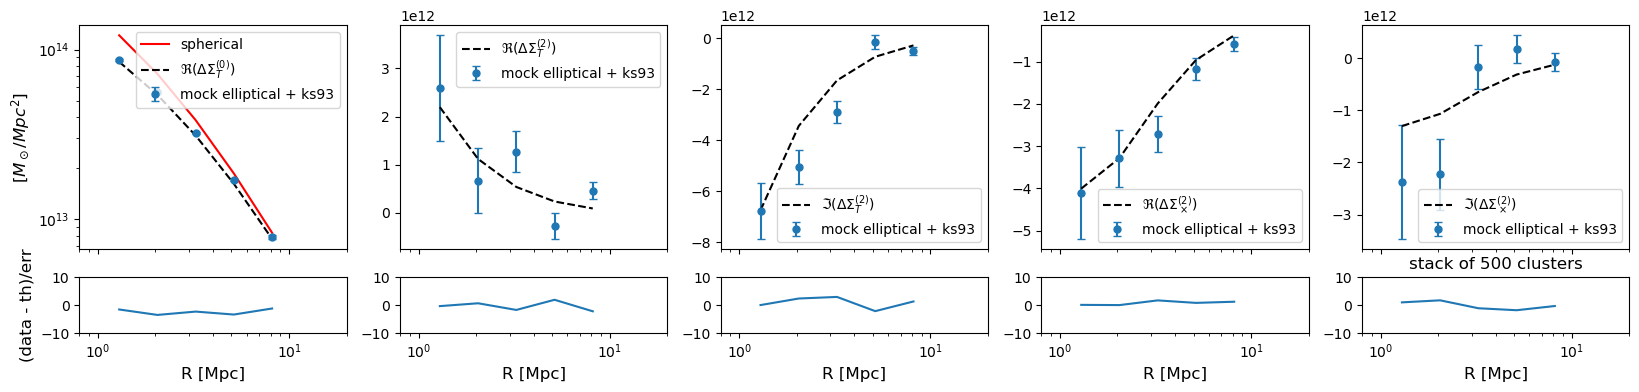

In [ ]:
signal = ['sheart_Re_0','sheart_Re_2','sheart_Im_2','shearx_Re_2','shearx_Im_2']
label = [r'$\Re(\Delta\Sigma_T^{(0)})$',r'$\Re(\Delta\Sigma_T^{(2)})$',r'$\Im(\Delta\Sigma_T^{(2)})$',r'$\Re(\Delta\Sigma_\times^{(2)})$',r'$\Im(\Delta\Sigma_\times^{(2)})$']
fig, axs =plt.subplots(2, len(signal), figsize=(20, 4) ,gridspec_kw={'height_ratios': [2, .5]}, sharex = True, )
axs[0,0].plot(Rs, moo.eval_excess_surface_density(Rs, z), 'r', label = 'spherical')
for i, sig in enumerate(signal):
    axs[0,i].errorbar(Rs, np.array(p[sig]), err['std_'+sig], fmt=' ', marker = 'o', markersize=5, capsize=3,  label = 'mock elliptical + ks93')
    axs[0,i].plot(Rs, np.array(esd_multipoles[sig]), '--k',label = label[i])
    axs[1,i].plot(Rs, (np.array(esd_multipoles[sig])-np.array(p[sig]))/err['std_'+sig])
    axs[0,i].legend()
    axs[0,0].set_yscale('log')
    axs[0,i].set_xscale('log')
    axs[0,i].set_xlim(.8, 20)
    axs[1,i].set_ylim(-10,10)
    axs[1,i].set_xlabel('R [Mpc]', fontsize=12)
    axs[1,0].set_ylabel('(data - th)/err', fontsize=12)
    axs[0,0].set_ylabel(r'$[M_\odot/Mpc^2]$', fontsize=12)
plt.title('stack of 500 clusters')
plt.savefig('lensing_multipoles_mock_vs_theory.png', bbox_inches='tight', dpi=100)